##### Copyright 2020 The TensorFlow Quantum Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Meta-Learning for QAOA
*Written by Michael Broughton, Antonio J. Martinez, and Guillaume Verdon*

In this notebook you will explore the application of meta-learning techniques from [here](https://arxiv.org/abs/1907.05415) to improve initialization of QAOA.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/quantum/blob/research/metalearning_qaoa/metalearning_qaoa.ipynb)

## Import dependencies

In [2]:
!pip install --upgrade cirq==0.7.0

     |████████████████████████████████| 1.2MB 4.9MB/s 
     |████████████████████████████████| 1.8MB 51.0MB/s 
     |████████████████████████████████| 1.2MB 46.0MB/s 
     |████████████████████████████████| 5.3MB 49.3MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=e425c19a37b1cbcb46e04fab17948ce271d20113fb80c9969ce57b0f73204017
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [0]:
!pip install --upgrade tensorflow==2.1.0

     |██████████████████████████      | 343.8MB 1.3MB/s eta 0:01:03

In [0]:
!pip install tfq-nightly

In [0]:
import cirq
import networkx as nx
import numpy as np
import random
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq
np.random.seed(123)
random.seed(123)

## QAOA



The QAOA ansatz consists of repeated applications of a mixer Hamiltonian $\hat{H}_M$ and the cost Hamiltonian $\hat{H}_C$.  The total applied unitary is
$$\hat{U}(\eta,\gamma) = \prod_{j=1}^{p}e^{-i\eta_{j}\hat{H}_M}e^{-i\gamma_{j} \hat{H}_C},$$
where $p$ is the number of timesthe mixer and cost are applied; the parameters $\eta_j, \gamma_j$ are to be optimized to produce a bitstring of minimal energy with respect to $\hat{H}_C$.

One traditional family of Hamiltonians used in QAOA are the Ising models.  These are defined as
$$\hat{H}_\mathrm{P}=\sum_i h_i \hat{Z}^{(i)}+\sum_{i,j} J_{ij} \hat{Z}^{(i)}\hat{Z}^{(j)}.$$
There is a one-to-one mapping between weighted graphs and Ising models: $h_i$ can be thought of as the weight of a graph node $i$ and $J_{ij}$ can be thought of as the weight of a graph edge between nodes $i$ and $j$.  In applications such as [MaxCut](https://en.wikipedia.org/wiki/Maximum_cut), we have $h_i = 0$ and $J_{ij} = 1 \forall i, j$.  We this define a function that takes a graph and outputs the corresponding Ising model:

In [0]:
def maxcut_qaoa_from_graph(graph, p):
  qubits = cirq.GridQubit.rect(1, len(graph.nodes))
  qaoa_circuit = cirq.Circuit()
  # Initial equal superposition
  for qubit in qubits:
    qaoa_circuit += cirq.H(qubit)
  qaoa_symbols = []
  # Stack the parameterized costs and mixers
  for l_num in range(p):
    qaoa_symbols.append(sympy.Symbol("gamma_{}".format(l_num)))
    for e in graph.edges():
      qaoa_circuit += cirq.ZZ(qubits[e[0]], qubits[e[1]])**qaoa_symbols[-1]
    qaoa_symbols.append(sympy.Symbol("eta_{}".format(l_num)))
    for n in graph.nodes():
      qaoa_circuit += cirq.X(qubits[n])**qaoa_symbols[-1]
  # Define the cost as a Cirq PauliSum
  cost_op = None
  for e in graph.edges():
    if cost_op is None:
      cost_op = cirq.Z(qubits[e[0]])*cirq.Z(qubits[e[1]])
    else:
      cost_op += cirq.Z(qubits[e[0]])*cirq.Z(qubits[e[1]])
  return qaoa_circuit, qaoa_symbols, cost_op

## Meta-Learning for MaxCut

The idea of meta-learning for optimization is to train an outer-loop optimizer on many instances of a problem class, to enhance the efficiency of solving unseen instances.  In other words, the learner is attempting to extract the common structure among instances of a particular class of problems.

Here, you will use a recurrent neural network to find good initial parameter settings for MaxCut QAOA instances.  As shown in the [original paper](https://arxiv.org/abs/1907.05415), this is an effective method for overcoming the challenge of ["barren plateaus"](https://www.nature.com/articles/s41467-018-07090-4) in quantum machine learning.

To this end we define a function that generates a set of random MaxCut QAOA instances, based on graphs sampled from an [Erdős–Rényi](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) distribution:

In [0]:
def generate_data(n_nodes, n_points):
  datapoints = []
  costs = []
  for _ in range(n_points):
    random_graph = nx.gnp_random_graph(n_nodes, p=3. / n_nodes)
    circuit, symbols, cost_op = maxcut_qaoa_from_graph(random_graph, 1)
    datapoints.append(circuit)
    costs.append([cost_op])
  return datapoints, symbols, costs

Since our recurrent neural network will have both classical and quantum components, we will need to define a custom RNN layer:

In [0]:
class QRNN(tf.keras.layers.Layer):
  def __init__(self, symbol_names):
    super(QRNN, self).__init__()
    self.shared = tf.keras.layers.Dense(25, name="shared")
    self.state = tf.keras.layers.Dense(25, name="state")
    self.params = tf.keras.layers.Dense(2, name="params")
    self.expectation = tfq.layers.Expectation()
    self.symbol_names = symbol_names

  def call(self, inputs):
    circuits = inputs[0]
    ops = inputs[1]
    state = inputs[2]
    params = inputs[3]
    prev_output = inputs[3]
    joined = tf.keras.layers.concatenate([state, params, prev_output])
    shared = self.shared(joined)
    s_inp = self.state(shared)
    p_inp = self.params(shared)
    exp_out = self.expectation(circuits,
                               symbol_names=self.symbol_names,
                               symbol_values=p_inp,
                               operators=ops)
    return [circuits, ops, s_inp, p_inp, exp_out]

This layer is stacked to produce the meta-learner RNN.  We choose 5 shots of optimization:

In [0]:
# Generate random MaxCut instances as training data.
N_QUBITS = 10

# For a more accurate optimizer on testing data, increase N_POINTS
N_POINTS = 500
circuits, symbols, ops = generate_data(N_QUBITS, N_POINTS)
circuit_tensor = tfq.convert_to_tensor(circuits)
ops_tensor = tfq.convert_to_tensor(ops)

# Unroll the RNN through time.
state_inp = tf.keras.Input(shape=(25,))
params_inp = tf.keras.Input(shape=(2,))
exp_inp = tf.keras.Input(shape=(25,))

op_inp = tf.keras.Input(shape=(1,), dtype=tf.dtypes.string)
circuit_inp = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

rnn_0 = QRNN(symbols)
rnn_1 = QRNN(symbols)
rnn_2 = QRNN(symbols)
rnn_3 = QRNN(symbols)
rnn_4 = QRNN(symbols)
output_0 = rnn_0([circuit_inp, op_inp, state_inp, params_inp, exp_inp])
output_1 = rnn_1(output_0)
output_2 = rnn_2(output_1)
output_3 = rnn_3(output_2)
output_4 = rnn_4(output_3)

Now we can set up a loss function over the 5 timesteps of our RNN QAOA optimizer:

In [0]:
@tf.function
def value_loss(unused, outputs):
    return tf.reduce_mean(outputs)

# It's important to have a good guess on the last shot of the optimization
loss = tf.keras.layers.average([
    0.1 * output_0[4], 0.2 * output_1[4], 0.3 * output_2[4],
    0.4 * output_3[4], 0.5 * output_4[4]
])

# Penalize jumping around randomly in the landscape.
penalizer = 10 * tf.reduce_sum(
    (output_0[3] - output_1[3])**2 + (output_1[3] - output_2[3])**2 +
    (output_2[3] - output_3[3])**2 + (output_3[3] - output_4[3])**2,
    axis=1)
full_loss = loss + penalizer

Finally we set and train our full Keras model:

In [0]:
# Can change these to random along with longer tine horizon and greater training
# data for more robust test set performance
initial_state = np.zeros((N_POINTS, 25)).astype(np.float32)
initial_params = np.zeros((N_POINTS, 2)).astype(np.float32)
initial_exp = np.zeros((N_POINTS, 25)).astype(np.float32)

# Our model will output it's parameter guesses along with the loss value that is
# computed over them. This way we can use the model to guess parameters later on
model = tf.keras.Model(inputs=[state_inp, params_inp, exp_inp, op_inp, circuit_inp],
    outputs=[
        output_0[3], output_1[3], output_2[3], output_3[3], output_4[3],
        full_loss
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=value_loss, loss_weights=[0, 0, 0, 0, 0, 1])

model.fit(x=[initial_state, initial_params, initial_exp, ops_tensor, circuit_tensor],
          y=[
              np.zeros((N_POINTS, 1)),
              np.zeros((N_POINTS, 1)),
              np.zeros((N_POINTS, 1)),
              np.zeros((N_POINTS, 1)),
              np.zeros((N_POINTS, 1)),
              np.zeros((N_POINTS, 1))
          ],
          epochs=20,
          batch_size=64,
          verbose=1)

Train on 500 samples
Epoch 1/20
500/500 [==============================] - 9s 18ms/sample - loss: -0.0027 - qrnn_loss: -2.8565e-04 - qrnn_1_loss: -4.5328e-04 - qrnn_2_loss: -5.3460e-04 - qrnn_3_loss: 8.9863e-05 - qrnn_4_loss: 7.5090e-04 - tf_op_layer_add_3_loss: -0.0028
Epoch 2/20
500/500 [==============================] - 5s 9ms/sample - loss: -0.0311 - qrnn_loss: -0.0015 - qrnn_1_loss: -0.0014 - qrnn_2_loss: -0.0017 - qrnn_3_loss: 1.9811e-04 - qrnn_4_loss: 0.0022 - tf_op_layer_add_3_loss: -0.0317
Epoch 3/20
500/500 [==============================] - 5s 9ms/sample - loss: -0.1145 - qrnn_loss: -0.0028 - qrnn_1_loss: -0.0030 - qrnn_2_loss: -0.0033 - qrnn_3_loss: 3.4117e-04 - qrnn_4_loss: 0.0045 - tf_op_layer_add_3_loss: -0.1160
Epoch 4/20
500/500 [==============================] - 5s 9ms/sample - loss: -0.2601 - qrnn_loss: -0.0035 - qrnn_1_loss: -0.0047 - qrnn_2_loss: -0.0047 - qrnn_3_loss: 0.0020 - qrnn_4_loss: 0.0076 - tf_op_layer_add_3_loss: -0.2619
Epoch 5/20
500/500 [==============

(Doing validation data.)

In [0]:
circuits, parameters, ops = generate_data(10, N_POINTS // 2)

circuit_tensor = tfq.convert_to_tensor(circuits)
ops_tensor = tfq.convert_to_tensor(ops)

initial_state = np.zeros((N_POINTS // 2, 25)).astype(np.float32)
initial_guesses = np.zeros((N_POINTS // 2, 2)).astype(np.float32)
initial_exp = np.zeros((N_POINTS // 2, 25)).astype(np.float32)

out1, out2, out3, out4, out5, _ = model(
    [initial_state, initial_guesses, initial_exp, ops_tensor, circuit_tensor])

one_vals = tf.reduce_mean(tfq.layers.Expectation()(
    circuit_tensor,
    symbol_names=parameters,
    symbol_values=out1,
    operators=ops_tensor)).numpy()
two_vals = tf.reduce_mean(tfq.layers.Expectation()(
    circuit_tensor,
    symbol_names=parameters,
    symbol_values=out2,
    operators=ops_tensor)).numpy()
three_vals = tf.reduce_mean(tfq.layers.Expectation()(
    circuit_tensor,
    symbol_names=parameters,
    symbol_values=out3,
    operators=ops_tensor)).numpy()
four_vals = tf.reduce_mean(tfq.layers.Expectation()(
    circuit_tensor,
    symbol_names=parameters,
    symbol_values=out4,
    operators=ops_tensor)).numpy()
five_vals = tf.reduce_mean(tfq.layers.Expectation()(
    circuit_tensor,
    symbol_names=parameters,
    symbol_values=out5,
    operators=ops_tensor)).numpy()

average_cost_function_values = [
    one_vals, two_vals, three_vals, four_vals, five_vals
]
std_of_param_guess = [
    tf.math.reduce_std(out1).numpy(),
    tf.math.reduce_std(out2).numpy(),
    tf.math.reduce_std(out3).numpy(),
    tf.math.reduce_std(out4).numpy(),
    tf.math.reduce_std(out5).numpy()
]

print('-' * 80)
print('Average cost function values for each guess number across unseen instances:',
      average_cost_function_values)
print('Variance of parameter values guessed:', std_of_param_guess)

--------------------------------------------------------------------------------
Average cost function values for each guess number across unseen instances: [-0.93607825, -3.0742426, -4.011084, -4.235294, -4.2729025]
Variance of parameter values guessed: [0.06207718, 0.13089399, 0.17260134, 0.19353636, 0.20162843]


Explore a singular instances. Now this instance is on 12 qubits and not just 10.

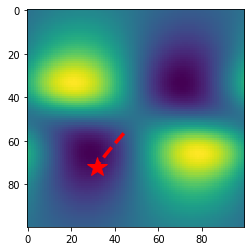

All guesses for test graph: [[-0.05920046, 0.06495389], [-0.12289892, 0.138889], [-0.1600413, 0.18516134], [-0.17817873, 0.20889395], [-0.18445928, 0.21879752]]
Cost function values for test graph: [-1.2702649869024754, -3.7216290906071663, -4.45371687412262, -4.50318269431591, -4.4711898267269135]
--------------------------------------------------------------------------------


In [0]:
test_graph_circuit, parameters, test_graph_op = generate_data(12, 1)

test_graph_circuit = test_graph_circuit[0]
test_graph_op = test_graph_op[0][0]

resolution = 100
input_vals = []
for i, a in enumerate(np.linspace(-0.5, .5, resolution)):
    for j, b in enumerate(np.linspace(-0.5, .5, resolution)):
        input_vals.append([a, b])

cost_vals = tfq.layers.Expectation()(test_graph_circuit,
                                     symbol_names=parameters,
                                     symbol_values=np.array(input_vals),
                                     operators=test_graph_op).numpy()

output_vals = np.empty((resolution, resolution))
for i, a in enumerate(np.linspace(-0.5, 0.5, resolution)):
    for j, b in enumerate(np.linspace(-0.5, 0.5, resolution)):
        output_vals[i][j] = cost_vals[i * resolution + j]

import matplotlib.pyplot as plt

plt.imshow(output_vals)

guess_0, guess_1, guess_2, guess_3, guess_4, _ = model([
    np.zeros((1, 25)).astype(np.float32),
    np.zeros((1, 2)).astype(np.float32),
    np.zeros((1, 25)).astype(np.float32),
    tfq.convert_to_tensor([[test_graph_op]]),
    tfq.convert_to_tensor([test_graph_circuit]),    
])
all_guesses = [guess_0, guess_1, guess_2, guess_3, guess_4]
all_guesses = [list(a.numpy()[0]) for a in all_guesses]


# This should be cleaned up...
def f(x):
    sim = cirq.Simulator()
    final_state = sim.simulate(test_graph_circuit, {
        parameters[0]: x[0],
        parameters[1]: x[1]
    }).final_state
    q = sorted(list(test_graph_circuit.all_qubits()))
    res = test_graph_op.expectation_from_wavefunction(
        final_state, qubit_map={h: i for i, h in enumerate(q)}).real
    return res


all_costs = [f(a) for a in all_guesses]

plt.plot((np.array(all_guesses)[:, 0] + 0.5) * resolution,
         (np.array(all_guesses)[:, 1] + 0.5) * resolution,
         c='r',
         linestyle='--',
         markevery=[4],
         marker='*',
         markersize=20,
         linewidth=3.5)
plt.show()

print('All guesses for test graph:', all_guesses)
print('Cost function values for test graph:', all_costs)
print('-' * 80)

As we can see from the above visual the RNN immediately begins guessing near the basin of attraction and continues to explore around the region looking to improve the estimate. Note the values in `all_costs` decreasing.